In [1]:
###############################################################################################
## Status: proof of principle to get a fast computation on the photon simulation 
## Desired workflow 
##       Input: Geant4 Optical hits
##       Calculation: Diego's & co semianalytical calculation in all its glory 
##       Output: Data frame w/ all photons in the form of [pixel Y, pixel Z, T, eventNumber] 
##
## Missing: cross check if all effects are there (Landau is missing for sure)
## Missing: rayleght scattering
### Missing for structure:
## Missing: Now this works 1 event at the time, needs to work for all events
## Missing: Need to re do the sampling and remove "bin_midpoints" from calculatePhotonOnPixel() inputs
##
## So, what did you do?!?
## Implemented slow portion of the code: hits of deposited to pixels combinatorics 
## Some cute pictures of possibly wrong light from kaons
## Each event takes < 10 sec to calculate
############################################################################

In [2]:
### %matplotlib notebook #> Comment out if you are doing several calculations and don't want to edit the plots
import argparse
import numpy as np
import uproot as uproot
#import uproot
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits import mplot3d        
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import time
import pandas as pd

In [3]:
### Calculate function for slow and fast light component times in ns
def fastAndSlowLightDistribution(t, fastPercent = 0.15, tau_fast = 5.0, tau_slow = 2100.):
    slowPercent = 1. - fastPercent
    return (fastPercent/tau_fast)*np.exp(-t/tau_fast) + (slowPercent/tau_slow)*np.exp(-t/tau_slow)

In [4]:
### Calculate sampling from fast and slow component (this can be sped up)
# None of this has anything to do with the specific energy deposition
# do this calculations only once, please!!

# Use default value for now, eventually can change here:
# tau_fast    = 5.    # ns
# tau_slow    = 2100. # ns
# fastPercent = 0.15  # Percentage of fast component 
def samplingLightProfile():
    weight = np.zeros(shape=(20000))
    t      = np.arange(0, 2000, 0.1 ) 
    weight = fastAndSlowLightDistribution(t)

    # Care to plot? 
    plotMe = True
    if (plotMe):
        fig = plt.figure()
        # Also, bins is defined here, which needs to change cause this is poorely written
        histo, bins, ignored1 = plt.hist(t, 1000, density=False, weights = weight)
        plt.xlabel("Time (ns)")
        plt.ylabel("Probability (arb. units)")
        plt.yscale('log')
        plt.xlim(-10, 2000)
        plt.ylim(1E-5, 0.1)
        plt.show()
    
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(histo)
    cdf = cdf / cdf[-1]
    return cdf, bin_midpoints

In [5]:
#### Specify a file by specifying the path to the file ####
file_path = './kaon.root'

In [6]:
### Detector Setup
### Since the event is generated at 0,0,0, it's possible you'll need to add an offset
xoffset = 0 #+50.0
yoffset = 0 #-250.0
zoffset = 0 #-130.0

#### Detector Dimensions (in cm) #####
xDimension = 300.
yDimension = 200.
zDimension = 200.

### Define the size of pixels (in cm) ###
PixelPitch = 4.

### Compute the number of pixels in each direction ####
nZPixels = int(zDimension/PixelPitch)
nYPixels = int(yDimension/PixelPitch)
nXPixels = int(xDimension/PixelPitch)


### Make an array of zeros for all the pixels ###
PixelMapYZ     = np.zeros([nYPixels, nZPixels], dtype = float)

### Define the Pixel Plane Orientation ###
planeNormalYZ = np.array([1, 0, 0]) #Unit vector in x
planePointYZ  = np.array([0, 1, 1]) #Any point on the YZ plane


In [7]:
### Open the file and then read out the data ####
f   = uproot.open(file_path)['event_tree']
# list of branches that we want to access
branches = [
            # event number
            'event',
            # generator info
            'generator_initial_number_particles', 'generator_initial_particle_pdg_code',
            'generator_initial_particle_px', 'generator_initial_particle_py', 'generator_initial_particle_pz',
            'generator_initial_particle_energy',
            'generator_final_number_particles', 'generator_final_particle_pdg_code',
            'generator_final_particle_px', 'generator_final_particle_py', 'generator_final_particle_pz',
            'generator_final_particle_energy',
            # MC particle information [Q_PIX_GEANT4]
            'particle_track_id', 'particle_pdg_code',
            'particle_mass', 'particle_initial_energy',
            # MC hit information [Q_PIX_GEANT4]
            'number_hits','hit_energy_deposit', 'hit_track_id', 'hit_process_key',
            'hit_start_x', 'hit_start_y', 'hit_start_z', 'hit_start_t','hit_process_key',
            'hit_end_x', 'hit_end_y', 'hit_end_z', 'hit_end_t']

# make the list of variables unique
branches = list(set(branches))
# create dataframe w/ all the simulated events
df = f.pandas.df(branches, flatten=False)

In [8]:
#testEventH = df.head(1)  
#testEvent.head()

testEventH = df.iloc[0]
#testEvent.head()
testEvent = df  
print(type(testEvent),type(testEventH))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


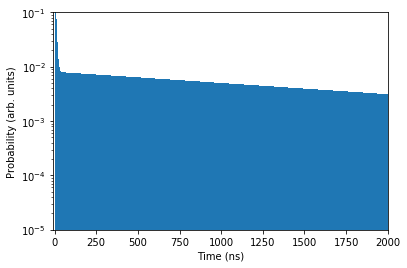

In [9]:
#%%time
i = 0
# get neutrino initial state particle (fsp) info
nu_isp_number = testEvent['generator_initial_number_particles'][i]
nu_isp_pdg    = testEvent['generator_initial_particle_pdg_code'][i]
nu_isp_px     = testEvent['generator_initial_particle_px'][i]
nu_isp_py     = testEvent['generator_initial_particle_py'][i]
nu_isp_pz     = testEvent['generator_initial_particle_pz'][i]
nu_isp_KE     = testEvent['generator_initial_particle_energy'][i]
        
# get neutrino final state particle (fsp) info
nu_fsp_number = testEvent['generator_final_number_particles'][i]
nu_fsp_pdg    = testEvent['generator_final_particle_pdg_code'][i]
nu_fsp_px     = testEvent['generator_final_particle_px'][i]
nu_fsp_py     = testEvent['generator_final_particle_py'][i]
nu_fsp_pz     = testEvent['generator_final_particle_pz'][i]
nu_fsp_KE     = testEvent['generator_final_particle_energy'][i]
        
# get the deposited energy info
Edep_number  = testEvent['number_hits'][i]
Edep_dq      = testEvent['hit_energy_deposit'][i]
Edep_x       = testEvent['hit_start_x'][i]
Edep_y       = testEvent['hit_start_y'][i]
Edep_z       = testEvent['hit_start_z'][i]
Edep_t       = testEvent['hit_start_t'][i]
Edep_trkID   = testEvent['hit_track_id'][i]
Edep_PDG     = testEvent['hit_process_key'][i]
Edep_G4Index = testEvent['hit_track_id'][i]

Edep_x = Edep_x + xoffset
Edep_y = Edep_y + yoffset
Edep_z = Edep_z + zoffset

n_photons_raw      = np.floor(Edep_dq*1E6 / 19.5)  ### using the floor function
thisPixelMapYZ     = np.zeros([nYPixels, nZPixels], dtype = float)

pixel_x = 0.
pixel_y = 0.
pixel_z = 0.


weight = np.zeros(shape=(20000))
t      = np.arange(0, 2000, 0.1 ) 
weight = fastAndSlowLightDistribution(t)
# Care to plot? 
plotMe = True
if (plotMe):
    fig = plt.figure()
    # Also, bins is defined here, which needs to change cause this is poorely written
    histo, bins, ignored1 = plt.hist(t, 1000, density=False, weights = weight)
    plt.xlabel("Time (ns)")
    plt.ylabel("Probability (arb. units)")
    plt.yscale('log')
    plt.xlim(-10, 2000)
    plt.ylim(1E-5, 0.1)
    plt.show()
    
bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(histo)
cdf = cdf / cdf[-1]

In [10]:
### All the photon calculation magik happens in this function
### Calculate all photons on a pixel and their time profile
def calculatePhotonOnPixel(Edep_x, Edep_y, Edep_z, pixel_x, pixel_y, pixel_z, Edep_t, cdf):
    # Calculate distance and direction from pixel to every energy dep 
    dis   = np.sqrt( (Edep_x - pixel_x)*(Edep_x - pixel_x) + (Edep_y - pixel_y)*(Edep_y - pixel_y) + (Edep_z - pixel_z)*(Edep_z - pixel_z))
    dir_x = (Edep_x - pixel_x) / dis
    dir_y = (Edep_y - pixel_y) / dis
    dir_z = (Edep_z - pixel_z) / dis
    ### Calculate little Omega (solid angle assuming on axis)
    pixelPitchSquared = PixelPitch*PixelPitch
    numerator         = pixelPitchSquared
    denomenator       = pixelPitchSquared + (4*dis*dis)
    littleOmega       = 4*np.arcsin(numerator / denomenator)

    ### Calculate the solid angle (taking into acount the angle between the pixel)
    NormDVec = np.array([dir_x, dir_y, dir_z])
    Dprod    = np.dot(planeNormalYZ,NormDVec)
    Omega    = np.abs(littleOmega * Dprod)
    
    # Calculate photon travel time from pixel to every energy dep
    # Before random spread is applied
    pho_t =  Edep_t + dis/11.23
    
    ### Calculate number of photon in each pixel ###
    PhotonCount   = np.floor((Omega * n_photons_raw)/(4*3.14159))
    # Stuff has to do w/ single pixel
    # Generate a number of throws correspoding to all photons arriving on the pixel
    values          = np.random.rand(int(np.sum(PhotonCount)))
    value_bins      = np.searchsorted(cdf, values)
    # random throws from the fast-slow distribution 
    random_from_cdf = bin_midpoints[value_bins]
    
    # Create time on each photon on pxl (before random applied)
    fancyTimeIndex  = np.repeat(pho_t, np.int_(PhotonCount))
    # pho_t is an array of lenght = number of photons on pixel
    # containing the time for each photon
    pho_t = fancyTimeIndex + random_from_cdf
    # Count the total number of photons on the pixel
    photonOnPixel  = np.sum(PhotonCount)
    return(photonOnPixel,pho_t)

(3309266, 3)


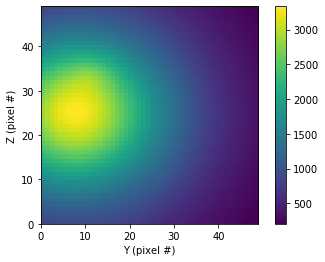

In [11]:

#cdf, bin_midpoints = samplingLightProfile()

listDf = []                  
for z in range(0, thisPixelMapYZ.shape[0]):
    for y in range(0, thisPixelMapYZ.shape[1]):
        thisPixelMapYZ[y,z], timeA = calculatePhotonOnPixel(Edep_x, Edep_y, Edep_z, pixel_x, pixel_y, pixel_z,Edep_t,cdf)        
        z_array = np.full_like(timeA, z)
        y_array = np.full_like(timeA, y)
        d = {"y": y_array, "z": z_array,'time':timeA}
        ph_df_temp = pd.DataFrame(d)
        listDf.append(ph_df_temp)
        pixel_y += PixelPitch
    pixel_y = 0.
    pixel_z += PixelPitch

# create photon dataframe w/ all timing information
ph_df = pd.concat(listDf)
print(ph_df.shape)

dy, dz = 1.0, 1.0
y = np.arange(0.0, nYPixels, dy) 
z = np.arange(0.0, nZPixels, dz) 

extent = np.min(y), np.max(y), np.min(z), np.max(z) 
#extent = 0,100,0,100

fig = plt.figure()
plt.xlabel("Y (pixel #)")
plt.ylabel("Z (pixel #)")
plt.imshow(thisPixelMapYZ, origin = 'lower', interpolation = 'nearest', extent = extent, aspect=(nZPixels/nYPixels)) #, vmin = 1, vmax = 120)
#plt.gca().invert_yaxis()
plt.colorbar()

# A Very Very Simple Plotter

In [12]:
## The plotter takes in input:
##  --> the query on the photon data frame
##  --> the output filename
##  It needs to be run at this point of the code because assumes that ph_df and thisPixelMapYZ are defined 
##  (this can improve)

## Right now we have 1 "photon data frame" per event: this might change
## Information currently saved in the "photon data frame" per photon: y,z of the pixel index, photon time

def plotter(query = "time > 9.", figname = "All_Photons.png", saveMe = True):
    thisPixelMapYZ_dummy = np.full_like(thisPixelMapYZ,0.)
    df_dummy = ph_df.query(query) # "10.<time < 11.")
    puppa = pd.crosstab(np.int_(df_dummy['y']),np.int_(df_dummy['z']))
    rows    = puppa.columns.values
    columns = puppa.index.values
    tile_col = np.tile(rows,  (columns.shape[0]))
    tile_row = np.repeat(columns,  (rows.shape[0]))
    thisPixelMapYZ_dummy[tile_row,tile_col] = puppa.to_numpy().flatten()
    fig = plt.figure()
    plt.xlabel("Y (pixel #)")
    plt.ylabel("Z (pixel #)")
    plt.imshow(thisPixelMapYZ_dummy, origin = 'lower', interpolation = 'nearest', extent = extent, aspect=(nZPixels/nYPixels), vmin = 1, vmax = 100)
    plt.colorbar()
    if saveMe:
        plt.savefig(figname) #"Img_10_11.png")


/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


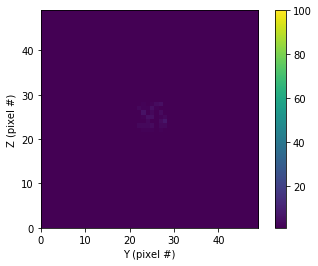

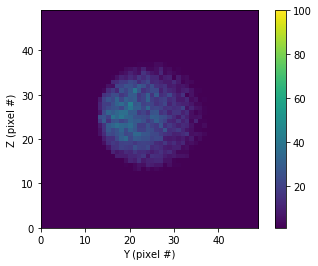

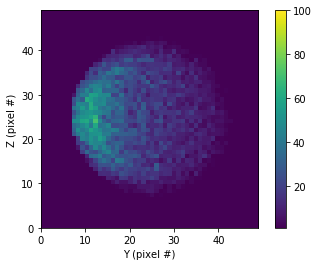

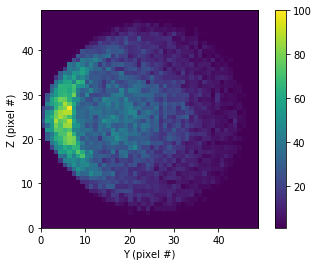

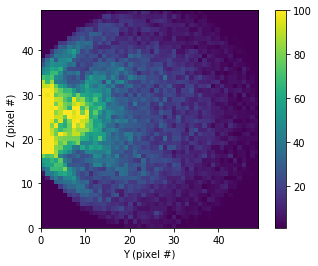

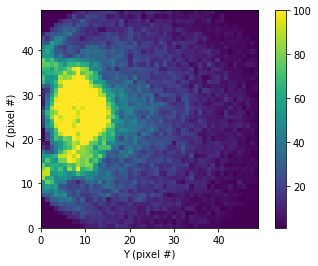

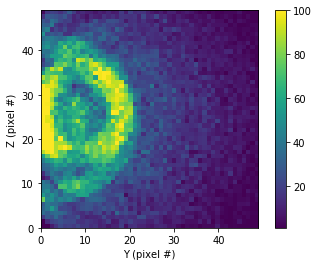

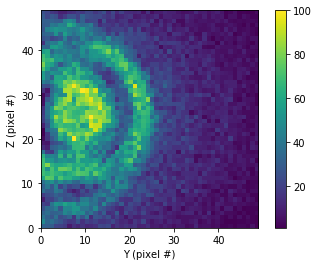

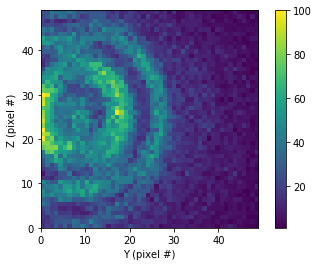

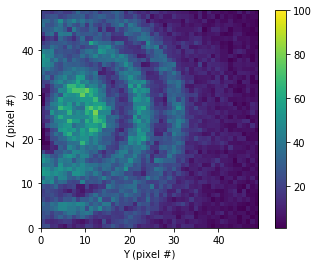

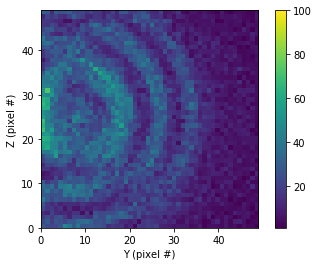

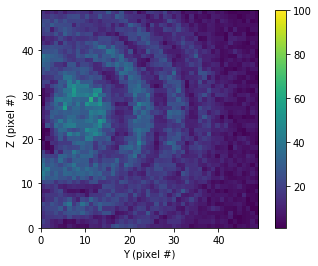

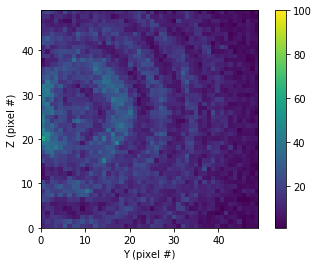

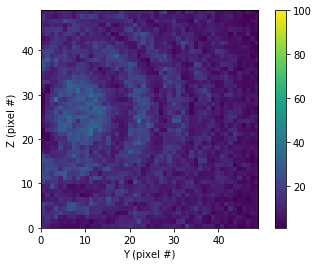

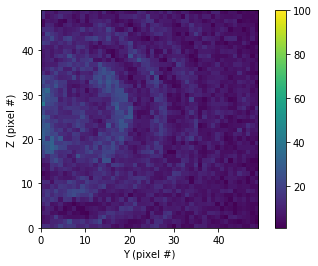

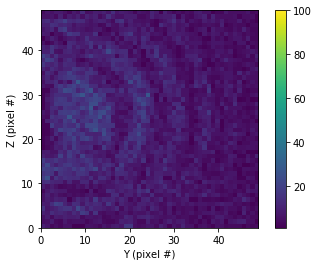

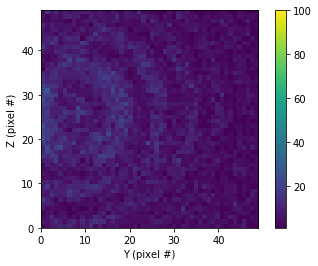

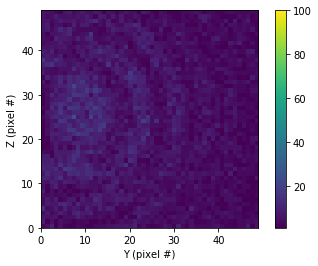

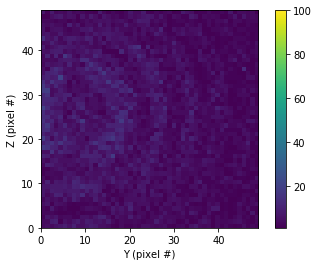

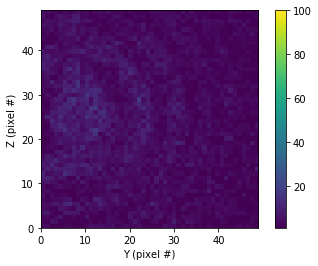

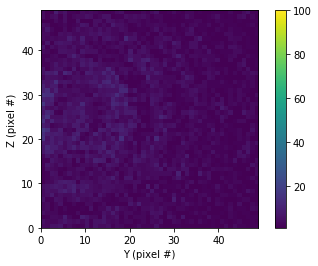

In [13]:
# Make a ton of images and save them, in this example, start from 9 ns go up to 30 ns with 1 ns gaps
for i in range(9,30,1):
    query  = str(i)+" < time < "+str(i+1)
    figname = "KaonEvt99/KaonEvt_2_"+str(i)+"_time_"+str(i+1)+"_1ns.png"
    plotter(query,figname)

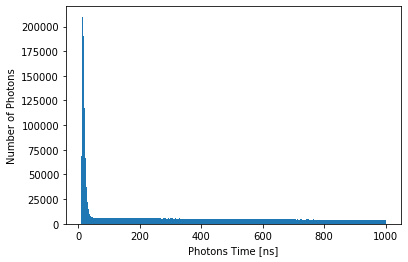

In [14]:
fig, ax = plt.subplots()
ax.hist(ph_df.loc[ph_df["time"] < 1000,"time"],bins=300)
plt.xlabel("Photons Time [ns]")
plt.ylabel("Number of Photons")

plt.show()

In [ ]:
# Old sampling code
